# Mess with VAE embeddings

In [1]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers.image_processor import VaeImageProcessor

In [2]:
#load components
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True)
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [3]:
# move to GPU
device = "cuda"
vae.to(device)
text_encoder.to(device)
unet.to(device)
""

''

In [4]:
# config
prompt = ["a picture of a red car", 'a picture of a green airplane']
height = 512
width = 512
num_inference_steps = 25
guidance_scale = 7.5
generator = torch.manual_seed(1)
batch_size = len(prompt)

In [5]:
# generate text tokens and embeddings 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [6]:
# empty embeddings used for classifier free guidance
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [7]:
# initialize latent variables
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(device)

In [8]:
latents = latents * scheduler.init_noise_sigma

In [9]:
# generate
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    latent_model_input = torch.cat([latents] *2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    noise_pred_uncond, noise_pred_text =noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/26 [00:00<?, ?it/s]

/pfs/data5/home/kn/kn_kn/kn_pop531500/venv/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:78.)
  return F.conv2d(input, weight, bias, self.stride,


In [10]:
latents.shape

torch.Size([2, 4, 64, 64])

In [11]:
import numpy as np
def interp(x, y, steps):
    res = torch.ones([steps+1,4,64,64])
    for d0 in range(len(x)): 
        for d1 in tqdm(range(len(x[d0]))):
            for d2 in range(len(x[d0][d1])):
                step =  (y[d0][d1][d2] - x[d0][d1][d2]) / steps
                for s in range(steps+1):
                    res[s][d0][d1][d2] = x[d0][d1][d2] + step*s 
    return res

def interp_gpu(x, y, steps):
    # Expand dimensions to match the target shape

    # Create a linear space tensor for steps
    s_values = torch.linspace(0, 1, steps, device='cuda')

    # Expand dimensions to allow broadcasting
    s_values = s_values.unsqueeze(1).unsqueeze(1).unsqueeze(1)

    # Calculate the entire interpolation in a single operation
    res = x + (y - x) * s_values

    return res
                

In [12]:
#latents_int = interp(latents[0], latents[1], 200).to('cuda')
#latents_int.shape

In [13]:
#%%timeit -n1 -r1
latents_int= interp_gpu(latents[0], latents[1], 50).to('cuda')
latents_int.shape

torch.Size([50, 4, 64, 64])

In [14]:
# scale and decode the image latents with vae
latents_scaled = 1 / 0.18215 * latents_int
with torch.no_grad():
    vae.enable_slicing()
    image = vae.decode(latents_scaled).sample

In [15]:
processor = VaeImageProcessor()
out = processor.postprocess(image)

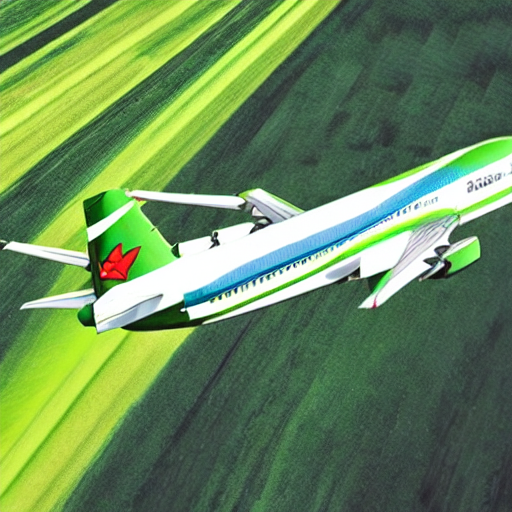

In [16]:
from IPython import display
for o in out:
    display.clear_output(wait=True)
    display.display(o)

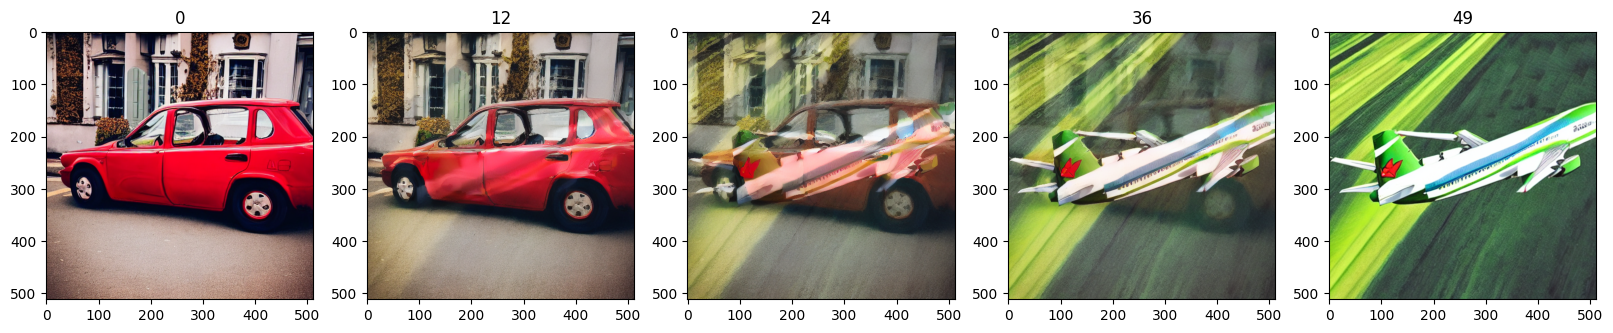

In [17]:
from utils.show import grid
grid(out)